<a href="https://colab.research.google.com/github/damzC/nlp/blob/main/Conversational_Chatbot_RASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Conversational Chatbot using Rasa and Python

**Problem**: In many cases, clients do not want to share their data and since  majority of the avialable tools are cloud-based and provide software as a service so you can not run them internally in your environment and you need to send your data to the third party. 

**Solution**: With <b>RASA stack</b>, an open-source customizable AI tool there is no such issue. You can build, deploy or host Rasa internally in your server or environment with complete control over it.

Rasa comes up with 2 components:

**Rasa NLU:** NLU deals with teaching a chatbot on how to understand user inputs.

**Rasa Core:** Deals with teaching a chatbot on how to respond to user’s query.

## Starting Jupyter Notebook with necessary imports

In [ ]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

# Installations
* Rasa NLU
* Rasa Core
* SpaCy Language Model

In [ ]:
import sys
python = sys.executable

!pip install rasa

# Run in your environment for installing rasa core and rasa nlu:
!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy]===0.12.3;

# Install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;


     |████████████████████████████████| 696kB 11.1MB/s 
     |████████████████████████████████| 133kB 29.7MB/s 
     |████████████████████████████████| 348kB 19.5MB/s 
     |████████████████████████████████| 3.0MB 17.7MB/s 
     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 460kB 52.5MB/s 
     |████████████████████████████████| 122kB 59.6MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 112kB 61.3MB/s 
     |████████████████████████████████| 665kB 44.8MB/s 
     |████████████████████████████████| 4.3MB 50.5MB/s 
     |████████████████████████████████| 1.2MB 44.0MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
   

     |████████████████████████████████| 133kB 12.2MB/s 
     |████████████████████████████████| 133kB 10.0MB/s 
     |████████████████████████████████| 307kB 17.8MB/s 
     |████████████████████████████████| 4.9MB 27.8MB/s 
     |████████████████████████████████| 49.1MB 65kB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 665kB 50.0MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 5.9MB 7.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 41.9MB/s 
     |████████████████████████████████| 133kB 58.4MB/s 
     |████████████████████████████████| 204kB 61.4MB/s 
     |████████████████████████████████| 3.1MB 45.2MB/s 
     |████████████████████████████████| 2

# Importing the Installations

In [ ]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))


rasa_nlu: 0.12.3 rasa_core: 0.9.6
Loading spaCy language model...
Hello world!


# 1. Teaching the bot to understand user inputs using Rasa NLU

## Preparing the NLU Training Data - Defining the intent
Intent is understanding what the user wants to say. For example — if the user says “Reserve a table at Cliff House tonight” the intent can be classified as to reserve/book the table.

Pay attention to the use of entity <b>PERSON</b> based on Spacy naming. For <b>CRFEntityExtractor</b> you can use your own names and they will be passed as entities to the dialogue engine. Spacy actually works quite independently so it will recognize all entities regardless of their presence in the NLU data and pass them to Rasa Core.

In [ ]:
nlu_md = """

## intent:greet
- hey
- hello
- hi
- Hi

## intent:fine_ask
- I am good, how are you doing?
- I'm fine, how are you?
- I'm good, how are you?

## intent:my_name_is
- I am [Raj](PERSON)
- I am [Pushkar](PERSON)
- I am [Sampriti](PERSON)
- I'm [Prerna](PERSON)
- I am [Apoorva](PERSON)
- im [Varun](PERSON)
- My name is [Nikhil](PERSON)


## intent:fine_normal
- I am doing great
- I'm doing great
- I'm fine
- I'm good
- great

## intent: askbot
- Who are you?
- Tell me about you.
- Can I know more about you?
- Tell me about yourself.
- Who's this?
- Who's there?
- Anybody there?
- Tell me who are you

## intent:thanks
- Thanks
- Thank you so much

## intent:goodbye
- Bye
- Bbye
- sure
- No Thankyou
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


## Defining the NLU Model Configuration

In [ ]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                     # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


## Training the NLU Model.

In [ ]:
# !pip install sklearn_crfsuite

In [ ]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 33 (7 distinct intents)
	- Found intents: 'fine_normal', 'askbot', 'goodbye', 'fine_ask', 'greet', 'my_name_is', 'thanks'
	- entity examples: 7 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train compone

Fitting 2 folds for each of 6 candidates, totalling 12 fits


## Evaluating the NLU model on a random text

In [ ]:
  pprint(interpreter.parse("I'm great"))

{
  "intent": {
    "name": "fine_normal",
    "confidence": 0.5947546522239241
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "fine_normal",
      "confidence": 0.5947546522239241
    },
    {
      "name": "my_name_is",
      "confidence": 0.10576250435349184
    },
    {
      "name": "fine_ask",
      "confidence": 0.07109041828572583
    },
    {
      "name": "thanks",
      "confidence": 0.07039751906550513
    },
    {
      "name": "goodbye",
      "confidence": 0.06876398420766941
    },
    {
      "name": "askbot",
      "confidence": 0.04563658311440317
    },
    {
      "name": "greet",
      "confidence": 0.043594338749280474
    }
  ],
  "text": "I'm great"
}


## Evaluating the NLU model on a test data
(Here we are using the training data, i.e., nlu.md but it is recommended to use unseen data)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 33 (7 distinct intents)
	- Found intents: 'fine_normal', 'askbot', 'goodbye', 'fine_ask', 'greet', 'my_name_is', 'thanks'
	- entity examples: 7 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 33 examples that have a defined intent out of 33 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9151515151515152
INFO:rasa_nlu.evaluate:Precision: 0.898989898989899
INFO:rasa_nlu.evaluate:Accuracy:  0.9393939393939394
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

     askbot       1.00      1.00      1.00         8
   fine_ask       1.00      1.00      1.00         3
fine_normal       1.00     

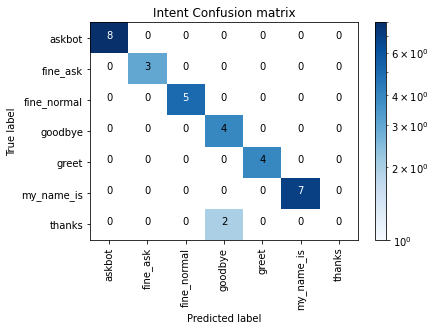

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9914244572131583
INFO:rasa_nlu.evaluate:Precision: 0.9922566371681416
INFO:rasa_nlu.evaluate:Accuracy:  0.9911504424778761
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

     PERSON       0.88      1.00      0.93         7
  no_entity       1.00      0.99      1.00       106

avg / total       0.99      0.99      0.99       113



In [ ]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# 2. Teaching the bot to respond using Rasa Core

## 1. Writing  Stories

<b>stories_md</b> defines the sample interaction between the user and chatbot in terms of intent and action taken by the bot.

If the bot gets the intent of booking a table and entities like place and time still, there is an entity missing — <i>no of people</i> and that would make the next action from the bot.

In [ ]:
stories_md = """

## fallback
- utter_default

## greeting path 1
* greet
- utter_greet1

## my_name_is
* my_name_is
- utter_its_nice_to_meet_you
  
## fine path 1
* fine_normal
- utter_help

* askbot
- utter_ask_bot   

    
## fine path 2
* fine_ask
- utter_reply

## thanks path 1
* thanks
- utter_anything_else

## bye path 1
* goodbye
- utter_goodbye

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


## 2. Defining a Domain
### Domain(domain.yml)
The domain consists of five key parts consisting of intents, entities, slots, actions, and templates.

<b>slots:</b> Slots are basically bot’s memory. They act as a key-value store which can be used to store information the user provided (e.g their home city) as well as information gathered about the outside world (e.g. the result of a database query).


<b>entity:</b> Entity is to extract the useful information from the user input. From the example above <i>“Reserve a table at Cliff House tonight”</i> the entities extracted would be place and time. Place — Cliff House and Time — tonight.

<b>intent: </b> Intent is understanding what the user wants to say. For example — if the user says <i>“Reserve a table at Cliff House tonight”</i> the intent can be classified as to reserve/book the table.

<b>actions:</b> Actions are bots response to user input. There are 3 kinds of actions in Rasa Core: <b>default actions, utter actions & custom actions</b>

<b>templates:</b> templates define the actual text responses used by the dialogue engine. The engine will pick one random response out of all the options. Notice that <b>utter_its_nice_to_meet_you</b> uses <b>PERSON</b> slot in the response to personalize it.

In [ ]:
domain_yml = """
slots:
  PERSON:
    type: text
  
entities:
- categories

intents:
- greet
- fine_ask
- my_name_is
- fine_normal
- thanks
- goodbye
- askbot

actions:
- utter_greet
- utter_reply
- utter_goodbye
- utter_default
- utter_its_nice_to_meet_you
- utter_greet1
- utter_ask_bot
- utter_help
- utter_anything_else

templates:

  utter_greet:
    - text: Hey {PERSON}, how are you?
    - text: Hello {PERSON}, How are you doing?
    - text: Hello {PERSON}, What can I do for you?
  
  utter_greet1:
    - text: Hey,I am Edureka's Chat bot designed for AI-ML PGP. I am still developing like you. Can I know your name?
    
  utter_its_nice_to_meet_you:
    - It's nice to meet you, {PERSON}. How are you?
    - Nice to meet you, {PERSON}
  
  utter_reply:
    - text: I'm doing great. Please let me know what I can do for you.
    - text: I'm doing great. Tell me How can I help you today?
    - text: I am good. Let me know how I can help you.
  
  utter_help:
    - text: Great {PERSON}. How can I help you?
    - text: Great {PERSON}. Tell me How can I help you?
    
  utter_anything_else:
    - text: No worries {PERSON}. Is there anything else I can help you with?
    - text: No worries {PERSON}. Let me know if there is anything else I can help you with

  utter_ask_bot:
    - text: If you see currently I am a basic chatbot with limited functionalities. Why don't you try to train me, {PERSON} and add more functionalities in me. My potential is endless.
    
  utter_goodbye:
    - text: Bye and have a nice day
    - text: Bbye and have a nice day
    
  utter_default:
    - text: I am not sure what you're aiming for
    - text: I am sorry but I am not able to get you.
    - text: My appologies but I am not able to get you
  
"""


%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


In [ ]:
#Skip this step if you already have the requirement
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 13.5MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


## Training a Dialogue Model

In [ ]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(max_history=5), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.1,
    epochs=1000
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
Using TensorFlow backend.
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
Processed Story Blocks: 100%|██████████| 7/7 [00:00<00:00, 284.49it/s, # trackers=18]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 289/289 [00:01<00:00, 165.77it/s, # actions=461]
INFO:rasa_core.featurizers:Created 461 action examples.
Processed actions: 461it [00:00, 1135.85it/s, # examples=461]
INFO:rasa_core.policies.memoization:Memorized 461 unique action examples.
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 289/289 [00:02<00:00, 142.50it/s, # actions=461]
INFO:rasa_core.featurizers:Created 461 action examples.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6784      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                363       
_________________________________________________________________
activation_1 (Activation)    (None, 11)                0         
Total params: 7,147
Trainable params: 7,147
Non-trainable params: 0
_________________________________________________________________
Train on 414 samples, validate on 47 samples
Epoch 1/1000
414/414 [==============================] - 0s - loss: 2.3602 - acc: 0.1884 - val_loss: 2.2200 - val_acc: 0.5319
Epoch 2/1000
414/414 [==============================] - 0s - loss: 2.1858 - acc: 0.4952 - val_loss: 1.

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model


INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


# Talk to your Bot

In [ ]:
#from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue")
while True:

    a = input()
    if a == 'stop':
        break
    else:
        responses = agent.handle_message(a)
        for response in responses:
            print(response["text"])
        

Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue
hi
Hey,I am Edureka's Chat bot designed for AI-ML PGP. I am still developing like you. Can I know your name?
I am Raj
It's nice to meet you, raj. How are you?
I am great. How are you?
I'm doing great. Tell me How can I help you today?
Send an sms for me
Hey,I am Edureka's Chat bot designed for AI-ML PGP. I am still developing like you. Can I know your name?
Thank you
Bbye and have a nice day
stop
